In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#NLP Libraries
import re
import nltk
import spacy
from wordcloud import WordCloud
import gensim
from gensim.models.phrases import Phrases
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
!pip install --upgrade spacy
!python -m spacy download en_core_web_md

     |████████████████████████████████| 6.0 MB 2.0 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: spacy
    Found existing installation: spacy 3.2.2
    Uninstalling spacy-3.2.2:
      Successfully uninstalled spacy-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typi

In [3]:
#NLP Libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preparation

In [4]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
y_target = train_data.target
X_tweets = train_data.iloc[:, :-1]

In [5]:
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
n_disas = sum(train_data.target == 1)
n_non = sum(train_data.target == 0)
n_total = len(train_data)
print("Number of disaster tweets: " + str(n_disas))
print("Number of non disaster tweets: " + str(n_non))
print("Total number of tweets: " + str(n_total))

print("{0}% of Disaster Tweets and {1}% of Non-Disaster Tweets".format(round(n_disas/n_total * 100, 2), round(n_non/n_total * 100, 2)))



Number of disaster tweets: 3271
Number of non disaster tweets: 4342
Total number of tweets: 7613
42.97% of Disaster Tweets and 57.03% of Non-Disaster Tweets


In [8]:
target1_idx = y_target == 1
target0_idx = y_target == 0

In [9]:
train_data.text

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

Visualizing first tweets

In [10]:
tweets_train = X_tweets.text
print([(t) for t in tweets_train[:5]])

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', 'Forest fire near La Ronge Sask. Canada', "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected", '13,000 people receive #wildfires evacuation orders in California ', 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']


Visualiazing Hashtags in the Disaster Tweets

### Tokenization

## Vectorization

### Tokenization and Vectorization

In [11]:
nlp = spacy.load("en_core_web_sm")
def normalize_token(text):
    text2 = nlp(text)
    normalized_text = [w.lemma_.lower() for w in text2 if not w.is_stop 
                  and not w.is_punct and (w.is_alpha or w.is_digit) and w.has_vector]

    return normalized_text

In [12]:
norm_corpus = []
norm_disaster = []
norm_non = []
for i in train_data.index:
    text_preproc= normalize_token(train_data.text[i])
    norm_corpus.append(text_preproc)
    
    if train_data.target[i] == 1:
        norm_disaster.append(text_preproc)
    else:
        norm_non.append(text_preproc)

In [13]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(norm_corpus)

bigram = Phrases(norm_corpus, min_count=3, delimiter=' ')
trigram = Phrases(bigram[norm_corpus], min_count=3, delimiter=' ')

In [14]:
tweet_corpus = list(trigram[norm_corpus])
tweet_disas_corpus = list(trigram[norm_disaster])
tweet_non_corpus = list(trigram[norm_non])

In [15]:
tokens_corpus = [token for doc in tweet_corpus for token in doc]
counts  = nltk.FreqDist(tokens_corpus)

tokens_disas = [token for doc in tweet_disas_corpus for token in doc]
tokens_non = [token for doc in tweet_non_corpus for token in doc]

In [16]:
vocab   = len(counts.keys()) 
words   = sum(counts.values())
lexdiv  = float(words) / float(vocab)

print("The corpus has %i unique words and a total of %i words with a lexical diversity of %0.3f." % (vocab, words, lexdiv))

The corpus has 12849 unique words and a total of 56280 words with a lexical diversity of 4.380.


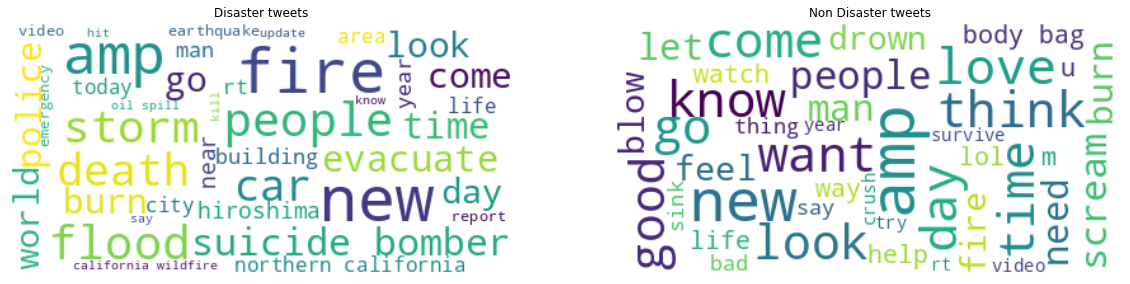

In [17]:
from wordcloud import WordCloud

# Create and generate a word cloud image:
wordcloud_disas = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(' '.join(tokens_disas))
wordcloud_non = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(' '.join(tokens_non))

# Display the generated image:
plt.subplots(1,2, figsize = (20,10))

plt.subplot(1,2,1)
plt.imshow(wordcloud_disas, interpolation='bilinear')
plt.axis("off")
plt.title("Disaster tweets")

plt.subplot(1,2,2)
plt.imshow(wordcloud_non, interpolation='bilinear')
plt.axis("off")
plt.title("Non Disaster tweets")
plt.show()

In [18]:
hashtags_disas = [re.findall(r"(#\w+)", t) for t in tweets_train[target1_idx]]
hashtags_disas = [h[0] for h in hashtags_disas if len(h)>0]

hashtags_non = [re.findall(r"(#\w+)", t) for t in tweets_train[target0_idx]]
hashtags_non = [h[0] for h in hashtags_non if len(h)>0]

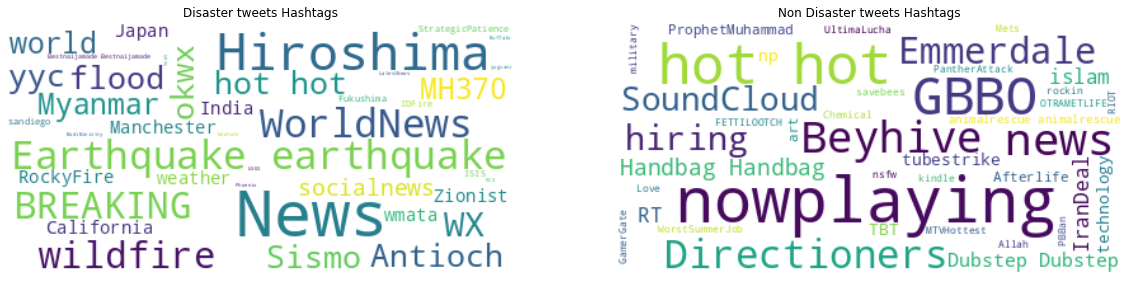

In [19]:
from wordcloud import WordCloud

# Create and generate a word cloud image:
wordcloud_disas = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(' '.join(hashtags_disas))
wordcloud_non = WordCloud(max_font_size=50, max_words=40, background_color="white").generate(' '.join(hashtags_non))

# Display the generated image:
plt.subplots(1,2, figsize = (20,10))

plt.subplot(1,2,1)
plt.imshow(wordcloud_disas, interpolation='bilinear')
plt.axis("off")
plt.title("Disaster tweets Hashtags")

plt.subplot(1,2,2)
plt.imshow(wordcloud_non, interpolation='bilinear')
plt.axis("off")
plt.title("Non Disaster tweets Hashtags")
plt.show()

In [20]:
import gensim
D = gensim.corpora.Dictionary(tweet_corpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')


The dictionary contains 12849 terms


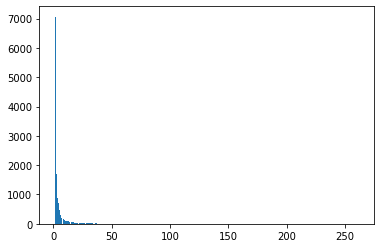

In [21]:
plt.hist(D.dfs.values(),300)
plt.show()

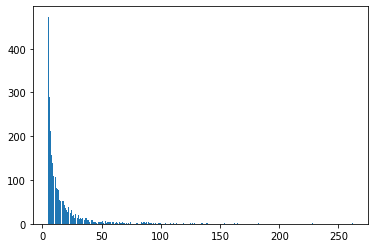

The dictionary contains 2486 terms


In [22]:
D.filter_extremes(no_below=5,no_above=0.8)
plt.hist(D.dfs.values(),300)
plt.show()

n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

In [23]:
class TextProcessing(object):
    
    def __init__(self):
        ## Load Modules
        self.nlp = spacy.load("en_core_web_sm")
        self.trigram = Phrases(bigram[norm_corpus], min_count=5, delimiter=' ')
        
    # allow the class instance to be called just like
    # a function that applies the preprocessing 
    def __call__(self, text):
        text_nlp = self.nlp(text)
        normalized_text = [w.lemma_.lower() for w in text_nlp if not w.is_stop 
                  and not w.is_punct and (w.is_alpha or w.is_digit)]

        return list(self.trigram[normalized_text])

In [24]:
analyzer = TextProcessing()

vectorizer = CountVectorizer(analyzer=analyzer,min_df = 5,max_df=0.8,max_features=2486)
tweets_train_bow = vectorizer.fit_transform(list(tweets_train))
print(vectorizer.get_feature_names())

['0', '02', '05', '06', '06 08', '07', '08', '08 05', '1', '10', '100', '101', '11', '11 year', '12', '12000 nigerian', '13', '14', '15', '150', '16', '17', '18', '19', '1945', '1980', '2', '20', '2011', '2013', '2014', '2015', '21', '22', '23', '24', '25', '26', '29', '3', '3 g', '3 word', '30', '300', '320', '33', '35', '4', '40', '4000', '5', '5 km', '50', '500', '6', '60', '600', '7', '70', '70 year', '731', '8', '9', '9 space', '90', '97', 'abandon', 'abc', 'abc news', 'ablaze', 'able', 'absolutely', 'abstorm', 'abuse', 'access', 'accident', 'accidentally', 'accord', 'account', 'accuse', 'acre', 'act', 'action', 'activate', 'active', 'activity', 'actual', 'actually', 'add', 'add video', 'address', 'admits', 'adult', 'advance', 'advisory', 'af', 'affect', 'afghan', 'afghanistan', 'afraid', 'africa', 'afterlife', 'afternoon', 'aftershock', 'age', 'ago', 'agree', 'ah', 'ahead', 'aid', 'aim', 'air', 'air accident', 'aircraft', 'aircraft debris', 'airplane', 'airplane accident', 'airpl

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
vecTfidf = TfidfTransformer()
tweets_train_tfidf = vecTfidf.fit_transform(tweets_train_bow)
print(tweets_train_tfidf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Model Classifiers 

In [26]:
# Train-Test partition
########################################
  # BOW Representation Classification #
########################################
id_tot = np.arange(tweets_train_tfidf.shape[0])
id_train, id_test = train_test_split(id_tot, test_size=0.4, random_state=42)

X_train_bow = tweets_train_bow[id_train,:]
X_test_bow = tweets_train_bow[id_test,:]
y_train = np.array(y_target)[id_train]
y_test = np.array(y_target)[id_test] 

### BOW Representation Classification

In [27]:
mNB = MultinomialNB()
mNB.fit(X_train_bow, y_train)
print("Score mNB: " + str(mNB.score(X_test_bow, y_test)))

cNB = ComplementNB()
cNB.fit(X_train_bow, y_train)
print("Score cNB: " + str(cNB.score(X_test_bow, y_test)))

SGD = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha=1e-3)
SGD.fit(X_train_bow, y_train)
print("Score SGD: " + str(SGD.score(X_test_bow, y_test)))

LR = LogisticRegression(C=1)
LR.fit(X_train_bow, y_train)
print("Score LR: " + str(LR.score(X_test_bow, y_test)))


Score mNB: 0.7918581746552856
Score cNB: 0.7859487852921865
Score SGD: 0.7879185817465528
Score LR: 0.7820091923834537


TF-IDF Representation Classification

In [28]:
# Train-Test partition
########################################
  # TF-IDF Representation Classification #
########################################
id_tot = np.arange(tweets_train_tfidf.shape[0])
id_train, id_test = train_test_split(id_tot, test_size=0.4, random_state=42)

X_train_tfidf = tweets_train_tfidf[id_train,:]
X_test_tfidf = tweets_train_tfidf[id_test,:]
y_train = np.array(y_target)[id_train]
y_test = np.array(y_target)[id_test] 

In [29]:
mNB = MultinomialNB()
mNB.fit(X_train_tfidf, y_train)
print("Score mNB: " + str(mNB.score(X_test_tfidf, y_test)))

cNB = ComplementNB()
cNB.fit(X_train_tfidf, y_train)
print("Score cNB: " + str(cNB.score(X_test_tfidf, y_test)))

SGD = SGDClassifier(loss = 'hinge', penalty = 'l2', alpha=1e-3)
SGD.fit(X_train_tfidf, y_train)
print("Score SGD: " + str(SGD.score(X_test_tfidf, y_test)))

LR = LogisticRegression(C=1)
LR.fit(X_train_tfidf, y_train)
print("Score LR: " + str(LR.score(X_test_tfidf, y_test)))


Score mNB: 0.7931713722915299
Score cNB: 0.7820091923834537
Score SGD: 0.7757715036112935
Score LR: 0.7941562705187131


Best Model LR with TF-IDF representation

### Grid Search BOW

In [30]:
lr_param = {
    'C':[1, 0.5, 0.1],
    'penalty':['l1', 'l2'],
    'solver':['liblinear']
}
nb_param = {
    'alpha':[0.01, 0.05, 0.1, .5, 1]
}
sgd_param = {
    'alpha':[0.01, 0.05, 0.1, .5, 1],
    'penalty':['l1', 'l2']
}
models = [{
        'name':'logistic reg',
        'estimator':LogisticRegression(),
        'hyperparameters':lr_param
     },
    {
        'name':'naive bayes',
        'estimator':MultinomialNB(),
        'hyperparameters':nb_param
    },
     {
        'name':'complement bayes',
        'estimator':ComplementNB(),
        'hyperparameters':nb_param
    },
     {
        'name':'linear svm',
        'estimator':SGDClassifier(),
        'hyperparameters':sgd_param
    }
]
for model in models:
    gs = GridSearchCV(estimator = model['estimator'],
                      param_grid = model['hyperparameters'],
                      scoring = 'f1',
                      cv = 10,
                      n_jobs = -1)
    gs.fit(X_train_bow, y_train)
    print(gs.best_estimator_)
    print(gs.best_score_)
    print(gs.best_params_)

LogisticRegression(C=0.5, solver='liblinear')
0.7180572247873717
{'C': 0.5, 'penalty': 'l2', 'solver': 'liblinear'}
MultinomialNB(alpha=0.5)
0.7364567461668198
{'alpha': 0.5}
ComplementNB(alpha=1)
0.7356139585402425
{'alpha': 1}
SGDClassifier(alpha=0.01)
0.5880882161487402
{'alpha': 0.01, 'penalty': 'l2'}


### Grid Search TF-IDF

In [31]:
lr_param = {
    'C':[1, 0.5, 0.1],
    'penalty':['l1', 'l2'],
    'solver':['liblinear']
}
nb_param = {
    'alpha':[0.01, 0.05, 0.1, .5, 1]
}
sgd_param = {
    'alpha':[0.01, 0.05, 0.1, .5, 1],
    'penalty':['l1', 'l2']
}
models = [{
        'name':'logistic reg',
        'estimator':LogisticRegression(),
        'hyperparameters':lr_param
     },
    {
        'name':'naive bayes',
        'estimator':MultinomialNB(),
        'hyperparameters':nb_param
    },
     {
        'name':'complement bayes',
        'estimator':ComplementNB(),
        'hyperparameters':nb_param
    },
     {
        'name':'linear svm',
        'estimator':SGDClassifier(),
        'hyperparameters':sgd_param
    }
]
for model in models:
    gs = GridSearchCV(estimator = model['estimator'],
                      param_grid = model['hyperparameters'],
                      scoring = 'f1',
                      cv = 10,
                      n_jobs = -1)
    gs.fit(X_train_tfidf, y_train)
    print(gs.best_estimator_)
    print(gs.best_score_)
    print(gs.best_params_)

LogisticRegression(C=1, solver='liblinear')
0.7143610281094707
{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
MultinomialNB(alpha=0.1)
0.730093413330416
{'alpha': 0.1}
ComplementNB(alpha=0.5)
0.738093450127067
{'alpha': 0.5}
SGDClassifier(alpha=1, penalty='l1')
0.12079492185216792
{'alpha': 1, 'penalty': 'l1'}


In [32]:
LR_model = LogisticRegression(C=1, solver='liblinear')
LR_model.fit(X_train_tfidf, y_train)
y_pred_LR = LR_model.predict(X_test_tfidf)
print("LR score: " + str(LR_model.score(X_test_tfidf, y_test)))

mNB_model = MultinomialNB(alpha=0.1)
mNB_model.fit(X_train_tfidf, y_train)
y_pred_mNB = mNB_model.predict(X_test_tfidf)
print("mNB score: " + str(mNB_model.score(X_test_tfidf, y_test)))

LR score: 0.7941562705187131
mNB score: 0.7915298752462245


In [33]:
from sklearn.metrics import classification_report
print("LR model")
print(classification_report(y_test, y_pred_LR))

print("mNB model")
print(classification_report(y_test, y_pred_mNB))

LR model
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1748
           1       0.82      0.66      0.73      1298

    accuracy                           0.79      3046
   macro avg       0.80      0.78      0.78      3046
weighted avg       0.80      0.79      0.79      3046

mNB model
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1748
           1       0.80      0.68      0.74      1298

    accuracy                           0.79      3046
   macro avg       0.79      0.78      0.78      3046
weighted avg       0.79      0.79      0.79      3046



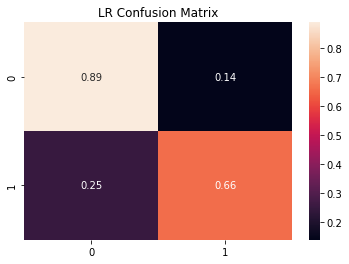

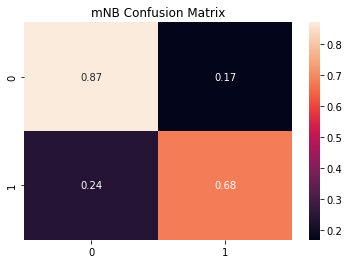

In [34]:
from sklearn.metrics import confusion_matrix

c = confusion_matrix(y_test, y_pred_LR)
plt.figure()
sns.heatmap(np.round(c/c.sum(axis=1), 2), annot= True)
plt.title("LR Confusion Matrix")
plt.show()

c = confusion_matrix(y_test, y_pred_mNB)
plt.figure()
sns.heatmap(np.round(c/c.sum(axis=1), 2), annot= True)
plt.title("mNB Confusion Matrix")
plt.show()

## Predicting New Tweets Function

In [35]:
def Pipe(data): 
    x = vectorizer.transform(data)
    x = vecTfidf.transform(x)
    preds_LR = LR_model.predict(x)
    return preds_LR


In [36]:
Pipe(test_data.text[0:15])

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [37]:
for i in test_data.text[:15]:
    print(i)

Just happened a terrible car crash
Heard about #earthquake is different cities, stay safe everyone.
there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
Apocalypse lighting. #Spokane #wildfires
Typhoon Soudelor kills 28 in China and Taiwan
We're shaking...It's an earthquake
They'd probably still show more life than Arsenal did yesterday, eh? EH?
Hey! How are you?
What a nice hat?
Fuck off!
No I don't like cold!
NOOOOOOOOO! Don't do that!
No don't tell me that!
What if?!
Awesome!


In [38]:
preds = Pipe(test_data.text)
submission = pd.DataFrame()
submission["id"] = test_data.id
submission["target"] = preds
submission.to_csv('submission.csv', index=False)